# Homework 1

## Part 1: Mortality Prediction in the ICU

The dataset you will use for this homework assignment can be found at the following link: https://drive.google.com/drive/folders/1n-fmx1jS_IWEsUj3EzlZ1qZ0hxqtSnZF?usp=sharing

Please make sure to copy the files to your own google drive folder and substitute the path to that file below to load the dataset.

In [ ]:
from google.colab import drive

# Will ask for authentication, click allow
drive.mount("/content/drive")

# Enter the correct path here
path_to_data_folder = "/content/drive/My Drive/hst_953_2022_data"


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the GOSSIS dataset into a pandas dataframe
df = pd.read_csv(os.path.join(path_to_data_folder, "gossis.csv"))

(a)

In [ ]:
# Enter the features corresponding to each category as a list below
# category (a)
# relevant features, all the features other than the ones listed below

# category (b)
irrelevant_features = ["encounter_id", "hospital_id", "patient_id",
                       "hospital_admit_source", "icu_admit_source"]

# category (c)
potentially_leaky_features = ["hospital_death",
                              "pre_icu_los_days",
                              "readmission_status",
                              "apache_2_diagnosis",
                              "apache_3j_diagnosis",
                              "apache_post_operative",
                              "arf_apache",
                              "urineoutput_apache",
                              "h1_blood_culture",
                              "h1_urine_culture",
                              "h1_sputum_culture",
                              "h1_serum_immunoglobulins_iga",
                              "h1_serum_immunoglobulins_igg",
                              "h1_serum_immunoglobulins_igm",
                              "h1_anca",
                              "h1_serum_complement_total_C3",
                              "h1_serum_complement_total_C4",
                              "d1_medication_name",
                              "d1_medication_dosage",
                              "d1_medication_name_complete",
                              "apache_4a_hospital_death_prob",
                              "apache_4a_icu_death_prob",
                              "apache_4a_icu_death_prob",
                              "apache_2_diagnosis",
                              "apache_3j_diagnosis"
                              ]

# Features to drop: categories (b) and (c)
features_to_drop = irrelevant_features + potentially_leaky_features

# Ground truth labels
label = "hospital_death"


# Note: collaborated and discussed inclusion and exculsion values with my peers (Siavash Raissi, Shyam Chandra, Moh Suufi)

(b)

In [ ]:
# Define the dataset and the target variable
X = df.drop(columns=features_to_drop+[label])
y = df[[label]]

# Populate the following list with the names of the binary features
# that you didn't drop from the dataset

remaining_binary_features = ["elective_surgery",
                             "gcs_unable_apache",
                             "intubated_apache",
                             "ventilated_apache",
                             "aids",
                             "cirrhosis",
                             "diabetes_mellitus",
                             "hepatic_failure",
                             "immunosuppression",
                             "leukemia",
                             "lymphoma",
                             "solid_tumor_with_metastasis"
                            ]

# Convert binary features into strings
# (to apply a specific preprocessing pipeline to those features later)
for c in remaining_binary_features:
    X[c] = X[c].fillna(-1)
    X[c] = X[c].astype(int)
    X[c] = X[c].astype(str)
    X[c] = X[c].replace("-1", np.nan)

# referred to this stack overflow article to help write the code above: https://stackoverflow.com/questions/21287624/convert-pandas-column-containing-nans-to-dtype-int

In [ ]:
# Preprocessing pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Each of the below transformers should be either a preprocessing step
# (i.e. a scaler/encoder/imputer) or a pipeline (chain) of preprocessing
# steps

# For numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # empty values are filled in with mean
    ('scaler', StandardScaler())]) # scaled to unit variance

# For categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # empty values filled with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) # unknown values for categorical variable ignored


preprocessing = ColumnTransformer(
    transformers=[
        (
            "num",
            numeric_transformer,
            selector(dtype_exclude=["category", object, "string"]),
        ),
        (
            "cat",
            categorical_transformer,
            selector(dtype_include=["category", object, "string"]),
        ),
    ]
)

preprocessing_pipeline = Pipeline(
    steps=[("preprocessing", preprocessing)]
)

In [ ]:
# Split the dataset into an 80%/20% train-test split
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Train the preprocessing pipeline on the train set and apply it on the test set
X_train = preprocessing_pipeline.fit_transform(X_train_raw)  # fit on train set

# extract new feature names
feature_names = list(preprocessing_pipeline[0].transformers_[0][2]) + list(preprocessing_pipeline[0].transformers_[1][1].get_feature_names_out())
X_train = pd.DataFrame(X_train, columns=feature_names)  # to dataframe type

# apply preprocessing pipeline to test set
X_test = pd.DataFrame(preprocessing_pipeline.transform(X_test_raw), columns=feature_names)

(c)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Used the following resource to help me write this code: https://www.youtube.com/watch?v=HYcXgN9HaTM&t=2s

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

# Fill out the following function to compute and return the different
# performance metrics of the input model. This is to avoid copying
# the same code to compute the metrics for each model

def evaluate_model(model, X_train, y_train, X_test, y_test, sample_weight=None):

  # predict train + test set
  y_train_predict = model.predict(X_train)
  y_test_predict = model.predict(X_test)

  # compute metrics for training set
  train_accuracy_score = accuracy_score(y_train, y_train_predict)
  train_precision_score = precision_score(y_train, y_train_predict)
  train_recall_score = recall_score(y_train, y_train_predict)
  train_f1_score = f1_score(y_train, y_train_predict)
  train_roc_auc_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

  # compute metrics for test set
  test_accuracy_score = accuracy_score(y_test, y_test_predict)
  test_precision_score = precision_score(y_test, y_test_predict)
  test_recall_score= recall_score(y_test, y_test_predict)
  test_f1_score = f1_score(y_test, y_test_predict)
  test_roc_auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

 # "metric dictionary" to access metrics OUTSIDE funtion
  return {
        'train_accuracy_score': train_accuracy_score,
        'train_precision_score': train_precision_score,
        'train_recall_score': train_recall_score,
        'train_f1_score': train_f1_score,
        'train_roc_auc_score': train_roc_auc_score,
        'test_accuracy_score': test_accuracy_score,
        'test_precision_score': test_precision_score,
        'test_recall_score': test_recall_score,
        'test_f1_score': test_f1_score,
        'test_roc_auc_score': test_roc_auc_score
    }

  pass

  # used the resources below to help me write this section of code:
  # https://stackoverflow.com/questions/60636444/what-is-the-difference-between-x-test-x-train-y-test-y-train-in-sklearn
  # https://www.youtube.com/watch?v=AQi71s-sRhE

In [ ]:
# Use evaluate_model to compute the different performance metrics for your linear regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# intialize + fit model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# use previous function
metrics = evaluate_model(log_reg, X_train, y_train, X_test, y_test)

# show data in a table (simple format)
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score'],
    'Train': [metrics['train_accuracy_score'], metrics['train_precision_score'], metrics['train_recall_score'], metrics['train_f1_score'], metrics['train_roc_auc_score']],
    'Test': [metrics['test_accuracy_score'], metrics['test_precision_score'], metrics['test_recall_score'], metrics['test_f1_score'], metrics['test_roc_auc_score']]
})
print('logistic regression performance metrics')
print(metrics_table)

# used the resources below to help me write this section of code:
# https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
# https://www.datarmatics.com/data-science/how-to-perform-logistic-regression-in-pythonstep-by-step/

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


logistic regression performance metrics
      Metric     Train      Test
0   Accuracy  0.927791  0.926457
1  Precision  0.693609  0.673977
2     Recall  0.291561  0.290485
3   F1-score  0.410547  0.405989
4  AUC score  0.883158  0.878863


(d)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and fit a random forest
# Use random_state=42 for consistency
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# used the following resource to help me write this section of code: https://www.youtube.com/watch?v=_QuGM_FW9eo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
# Use evaluate_model to compute the different performance metrics for your random forest

rf_metrics = evaluate_model(rf, X_train, y_train, X_test, y_test)

rf_metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score'],
    'Train': [rf_metrics['train_accuracy_score'], rf_metrics['train_precision_score'], rf_metrics['train_recall_score'], rf_metrics['train_f1_score'], rf_metrics['train_roc_auc_score']],
    'Test': [rf_metrics['test_accuracy_score'], rf_metrics['test_precision_score'], rf_metrics['test_recall_score'], rf_metrics['test_f1_score'], rf_metrics['test_roc_auc_score']]
})

print("random forest classifier performance metrics:")
print(rf_metrics_table)
print(type(rf_metrics))

# used the following resource to help me write this section of code: https://www.youtube.com/watch?v=_QuGM_FW9eo

random forest classifier performance metrics:
      Metric     Train      Test
0   Accuracy  0.999973  0.929128
1  Precision  1.000000  0.773333
2     Recall  0.999684  0.255829
3   F1-score  0.999842  0.384470
4  AUC score  1.000000  0.873930
<class 'dict'>


In [ ]:
!pip install xgboost

In [ ]:
import xgboost

# Create and fit an xgboost model
# Use random_state=42 for consistency
xgboost = xgboost.XGBClassifier(random_state=42)
xgboost.fit(X_train, y_train)

# used the following resource to help me write this section of code: https://www.youtube.com/watch?v=ap2SS0-XPcE

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Use evaluate_model to compute the different performance metrics for your xgboost model

xgboost_metrics = evaluate_model(xgboost, X_train, y_train, X_test, y_test)

xgboost_metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score'],
    'Train': [xgboost_metrics['train_accuracy_score'], xgboost_metrics['train_precision_score'], xgboost_metrics['train_recall_score'], xgboost_metrics['train_f1_score'], xgboost_metrics['train_roc_auc_score']],
    'Test': [xgboost_metrics['test_accuracy_score'], xgboost_metrics['test_precision_score'], xgboost_metrics['test_recall_score'], xgboost_metrics['test_f1_score'], xgboost_metrics['test_roc_auc_score']]
})

print("xgboost performance metrics:")
print(xgboost_metrics_table)

# used the following resource to help me write this section of code: https://www.youtube.com/watch?v=ap2SS0-XPcE

xgboost performance metrics:
      Metric     Train      Test
0   Accuracy  0.970410  0.927275
1  Precision  0.973786  0.651861
2     Recall  0.675095  0.342155
3   F1-score  0.797387  0.448760
4  AUC score  0.982688  0.892596


(e)

In [ ]:
print(type(metrics))
print(type(rf_metrics))
print(type(xgboost_metrics))

<class 'dict'>
<class 'dict'>
<class 'dict'>


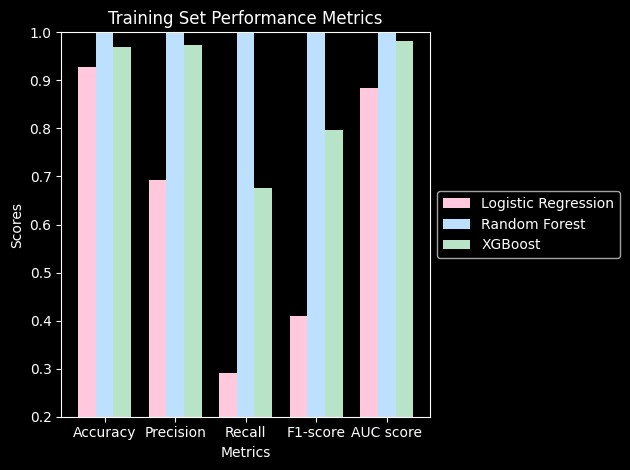

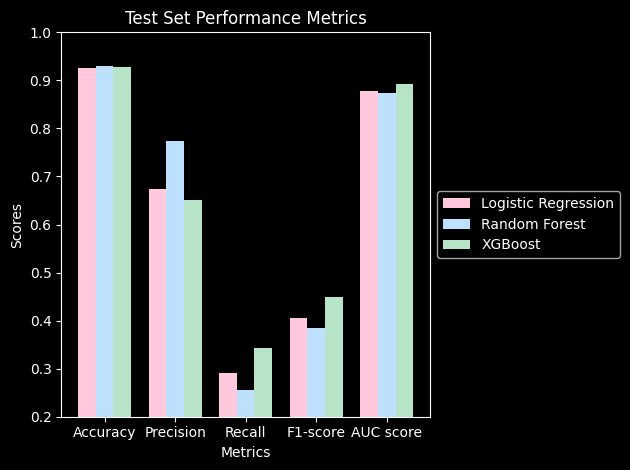

In [ ]:
# Plot the performance metrics on a histogram
# You may use any python library of your choice

import matplotlib.pyplot as plt
import numpy as np

# training set histogram
metrics_train = [metrics['train_accuracy_score'],
                 metrics['train_precision_score'],
                 metrics['train_recall_score'],
                 metrics['train_f1_score'],
                 metrics['train_roc_auc_score']]

rf_metrics_train = [rf_metrics['train_accuracy_score'],
                 rf_metrics['train_precision_score'],
                 rf_metrics['train_recall_score'],
                 rf_metrics['train_f1_score'],
                 rf_metrics['train_roc_auc_score']]

xgb_metrics_train = [xgboost_metrics['train_accuracy_score'],
                  xgboost_metrics['train_precision_score'],
                  xgboost_metrics['train_recall_score'],
                  xgboost_metrics['train_f1_score'],
                  xgboost_metrics['train_roc_auc_score']]

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
n_metrics = len(metrics_names)

bar_width = 0.25
index = np.arange(n_metrics)

plt.bar(index - bar_width, metrics_train, bar_width, label='Logistic Regression', color='#ffc8dd')
plt.bar(index, rf_metrics_train, bar_width, label='Random Forest', color='#bde0fe')
plt.bar(index + bar_width, xgb_metrics_train, bar_width, label='XGBoost', color='#b7e4c7')


plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Training Set Performance Metrics')
plt.xticks(index, metrics_names)
plt.ylim(0.2, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# test set histogram
metrics_test = [metrics['test_accuracy_score'],
                 metrics['test_precision_score'],
                 metrics['test_recall_score'],
                 metrics['test_f1_score'],
                 metrics['test_roc_auc_score']]

rf_metrics_test = [rf_metrics['test_accuracy_score'],
                 rf_metrics['test_precision_score'],
                 rf_metrics['test_recall_score'],
                 rf_metrics['test_f1_score'],
                 rf_metrics['test_roc_auc_score']]

xgb_metrics_test = [xgboost_metrics['test_accuracy_score'],
                  xgboost_metrics['test_precision_score'],
                  xgboost_metrics['test_recall_score'],
                  xgboost_metrics['test_f1_score'],
                  xgboost_metrics['test_roc_auc_score']]

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score']
n_metrics = len(metrics_names)

plt.bar(index - bar_width, metrics_test, bar_width, label='Logistic Regression', color='#ffc8dd')
plt.bar(index, rf_metrics_test, bar_width, label='Random Forest', color='#bde0fe')
plt.bar(index + bar_width, xgb_metrics_test, bar_width, label='XGBoost', color='#b7e4c7')

bar_width = 0.25
index = np.arange(n_metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Test Set Performance Metrics')
plt.xticks(index, metrics_names)
plt.ylim(0.2, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# used the resources below to help me write this section of code:
# https://www.w3schools.com/python/matplotlib_histograms.asp
# https://www.youtube.com/watch?v=siUJqANJhHc
# retrieved custom colors from https://coolors.co/palettes/trending

(f) (answer this in your report)



(g)

In [ ]:
!pip install shap

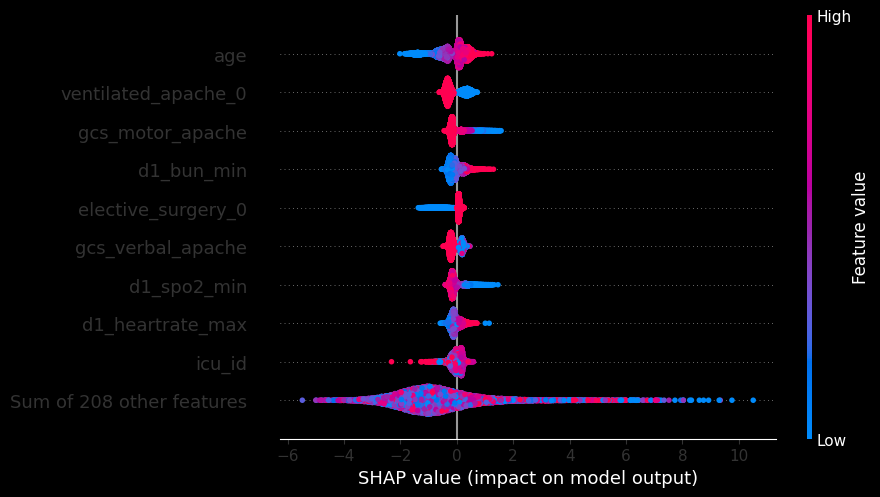

In [ ]:
import shap

# Compute and plot the shapley values of the xgboost model on a beeswarm plot
explainer = shap.Explainer(xgboost)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# I intially did not know was a beeswarm plot was. I used this resources below to help me write the code above:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
# https://www.youtube.com/watch?v=FiVevA8fBgg

(h)

In [ ]:
# Split the test set into cohorts in three different ways
# Remember to split both the input features and the ground truth labels!

# white/non-white cohort
white_pts_X = X_test_raw[X_test_raw["ethnicity"] == "Caucasian"]
nonwhite_pts_X = X_test_raw[X_test_raw["ethnicity"] != "Caucasian"]
white_pts_y = y_test[X_test_raw['ethnicity'] == "Caucasian"]
nonwhite_pts_y = y_test[X_test_raw['ethnicity'] != "Caucasian"]

# M/F cohort
male_pts_X = X_test_raw[X_test_raw['gender'] == 'M']
female_pts_X = X_test_raw[X_test_raw['gender'] == 'F']
male_pts_y = y_test[X_test_raw['gender'] == 'M']
female_pts_y = y_test[X_test_raw['gender'] == 'F']

# over/under 65 cohort
older65_pts_X = X_test_raw[X_test_raw['age'] < 65]
younger65_pts_X = X_test_raw[X_test_raw['age'] >= 65]
older65_pts_y = y_test[X_test_raw['age'] < 65]
younger65_pts_y = y_test[X_test_raw['age'] >= 65]

# used the following resource to help me write the code above: https://stackoverflow.com/questions/68884049/sklearn-train-test-split-split-a-dataset-to-compare-predicted-labels-with-ground

(i)

In [ ]:
# Compute the performance metrics below
# You may use the evaluate_model function from before
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

white_pts_X = pd.DataFrame(preprocessing_pipeline.transform(white_pts_X), columns=feature_names)
nonwhite_pts_X = pd.DataFrame(preprocessing_pipeline.transform(nonwhite_pts_X), columns=feature_names)
male_pts_X = pd.DataFrame(preprocessing_pipeline.transform(male_pts_X), columns=feature_names)
female_pts_X = pd.DataFrame(preprocessing_pipeline.transform(female_pts_X), columns=feature_names)
older65_pts_X = pd.DataFrame(preprocessing_pipeline.transform(older65_pts_X), columns=feature_names)
younger65_pts_X = pd.DataFrame(preprocessing_pipeline.transform(younger65_pts_X), columns=feature_names)

xgboost_white = evaluate_model(xgb_model, X_train, y_train, white_pts_X, white_pts_y)
xgboost_nonwhite = evaluate_model(xgb_model, X_train, y_train, nonwhite_pts_X, nonwhite_pts_y)
xgboost_male = evaluate_model(xgb_model, X_train, y_train, male_pts_X, male_pts_y)
xgboost_female = evaluate_model(xgb_model, X_train, y_train, female_pts_X, female_pts_y)
xgboost_old = evaluate_model(xgb_model, X_train, y_train, older65_pts_X, older65_pts_y)
xgboost_young = evaluate_model(xgb_model, X_train, y_train, younger65_pts_X, younger65_pts_y)

xgboost_cohort_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC score'],

    'White':     [xgboost_white['test_accuracy_score'],
                  xgboost_white['test_precision_score'],
                  xgboost_white['test_recall_score'],
                  xgboost_white['test_f1_score'],
                  xgboost_white['test_roc_auc_score']],

    'Nonwhite':  [xgboost_nonwhite['test_accuracy_score'],
                  xgboost_nonwhite['test_precision_score'],
                  xgboost_nonwhite['test_recall_score'],
                  xgboost_nonwhite['test_f1_score'],
                  xgboost_nonwhite['test_roc_auc_score']],

    'Male':      [xgboost_male['test_accuracy_score'],
                  xgboost_male['test_precision_score'],
                  xgboost_male['test_recall_score'],
                  xgboost_male['test_f1_score'],
                  xgboost_male['test_roc_auc_score']],

    'Female':    [xgboost_female['test_accuracy_score'],
                  xgboost_female['test_precision_score'],
                  xgboost_female['test_recall_score'],
                  xgboost_female['test_f1_score'],
                  xgboost_female['test_roc_auc_score']],

    'Age Above 65': [xgboost_old['test_accuracy_score'],
                     xgboost_old['test_precision_score'],
                     xgboost_old['test_recall_score'],
                     xgboost_old['test_f1_score'],
                     xgboost_old['test_roc_auc_score']],

    'Age Below 65': [xgboost_young['test_accuracy_score'],
                     xgboost_young['test_precision_score'],
                     xgboost_young['test_recall_score'],
                     xgboost_young['test_f1_score'],
                     xgboost_young['test_roc_auc_score']]
})

# Print the cohort performance metrics
print("XGBoost performance metrics across cohorts:")
print(xgboost_cohort_table)

# Used the following resources to help me write the above code:
# https://community.dataquest.io/t/how-to-apply-the-model-to-the-dataset/573509/2
# https://www.youtube.com/watch?v=aLOQD66Sj0g

XGBoost performance metrics across cohorts:
      Metric     White  Nonwhite      Male    Female  Age Above 65  \
0   Accuracy  0.928668  0.922680  0.927973  0.926505      0.951796   
1  Precision  0.669841  0.596059  0.646925  0.657360      0.611888   
2     Recall  0.346470  0.327913  0.337292  0.348118      0.364583   
3   F1-score  0.456710  0.423077  0.443404  0.455185      0.456919   
4  AUC score  0.892925  0.891871  0.894784  0.889987      0.923881   

   Age Below 65  
0      0.909716  
1      0.667360  
2      0.333680  
3      0.444906  
4      0.860946  


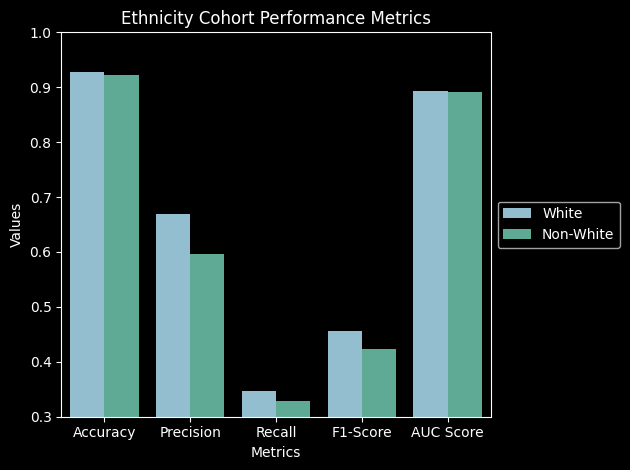

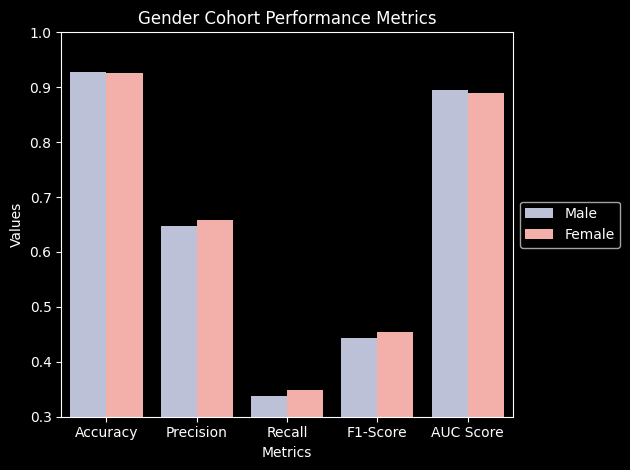

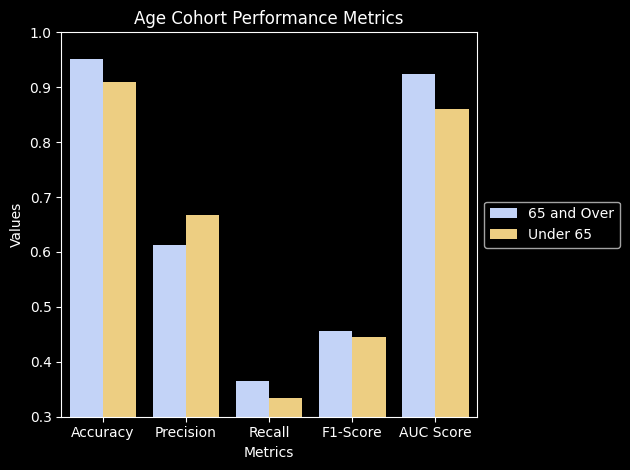

In [ ]:
# Plot the performance metrics on a histogram for each of the cohort splits

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ethnicity histogram
custom_pallete_1 = ["#89c2d9","#52b69a",]

ethnicity_info = {"Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC Score"],
                 "White": [xgboost_white['test_accuracy_score'], xgboost_white['test_precision_score'],
                           xgboost_white['test_recall_score'], xgboost_white['test_f1_score'],
                           xgboost_white['test_roc_auc_score']],
                  "Non-White": [xgboost_nonwhite['test_accuracy_score'], xgboost_nonwhite['test_precision_score'],
                               xgboost_nonwhite['test_recall_score'], xgboost_nonwhite['test_f1_score'],
                               xgboost_nonwhite['test_roc_auc_score']]}


ethnicity_df = pd.DataFrame(ethnicity_info)
ethnicity_df_melted = ethnicity_df.melt(id_vars='Metric', var_name='ethnicity', value_name='Metric Value')

sns.barplot(x='Metric', y='Metric Value', hue='ethnicity', data=ethnicity_df_melted, palette=custom_pallete_1)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Ethnicity Cohort Performance Metrics')
plt.ylim(0.3, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# gender histogram
custom_palette_2 = ["#b8bedd", "#ffa69e"]

gender_info = {"Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC Score"],
              "Male": [xgboost_male['test_accuracy_score'], xgboost_male['test_precision_score'],
                       xgboost_male['test_recall_score'], xgboost_male['test_f1_score'],
                       xgboost_male['test_roc_auc_score']],
              "Female": [xgboost_female['test_accuracy_score'], xgboost_female['test_precision_score'],
                         xgboost_female['test_recall_score'], xgboost_female['test_f1_score'],
                         xgboost_female['test_roc_auc_score']]}


gender_df = pd.DataFrame(gender_info)
gender_df_melted = gender_df.melt(id_vars='Metric', var_name='gender', value_name='Metric Value')

sns.barplot(x='Metric', y='Metric Value', hue='gender', data=gender_df_melted, palette=custom_palette_2)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Gender Cohort Performance Metrics')
plt.ylim(0.3, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# age histogram
custom_pallete_3 = ["#bbd0ff", "#ffd670"]

age_info = {"Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC Score"],
             "65 and Over": [xgboost_old['test_accuracy_score'], xgboost_old['test_precision_score'],
                             xgboost_old['test_recall_score'], xgboost_old['test_f1_score'],
                             xgboost_old['test_roc_auc_score']],
            "Under 65": [xgboost_young['test_accuracy_score'], xgboost_young['test_precision_score'],
                           xgboost_young['test_recall_score'], xgboost_young['test_f1_score'],
                           xgboost_young['test_roc_auc_score']]}


age_df = pd.DataFrame(age_info)
age_df_melted = age_df.melt(id_vars='Metric', var_name='age', value_name='Metric Value')


sns.barplot(x='Metric', y='Metric Value', hue='age', data=age_df_melted, palette=custom_pallete_3)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Age Cohort Performance Metrics')
plt.ylim(0.3, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# refreshed my knowledge on matplot via this resource: https://www.w3schools.com/python/matplotlib_histograms.asp
# refreshed my knowledge on seaborn via this resource: https://seaborn.pydata.org/generated/seaborn.histplot.html
# retrieved custom colors from https://coolors.co/palettes/trending

(j) Answer this question in your report

(k)

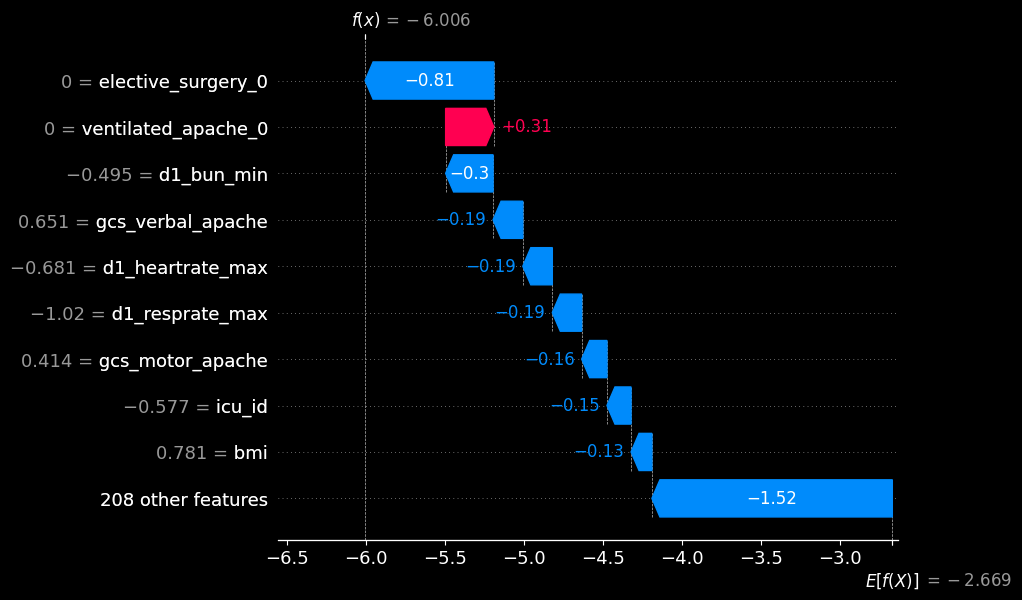

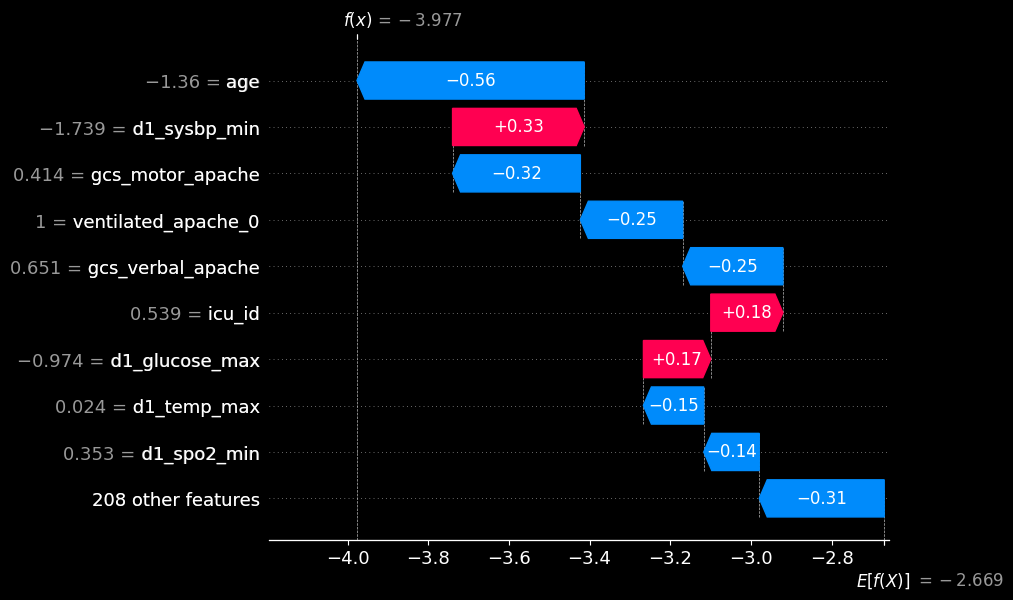

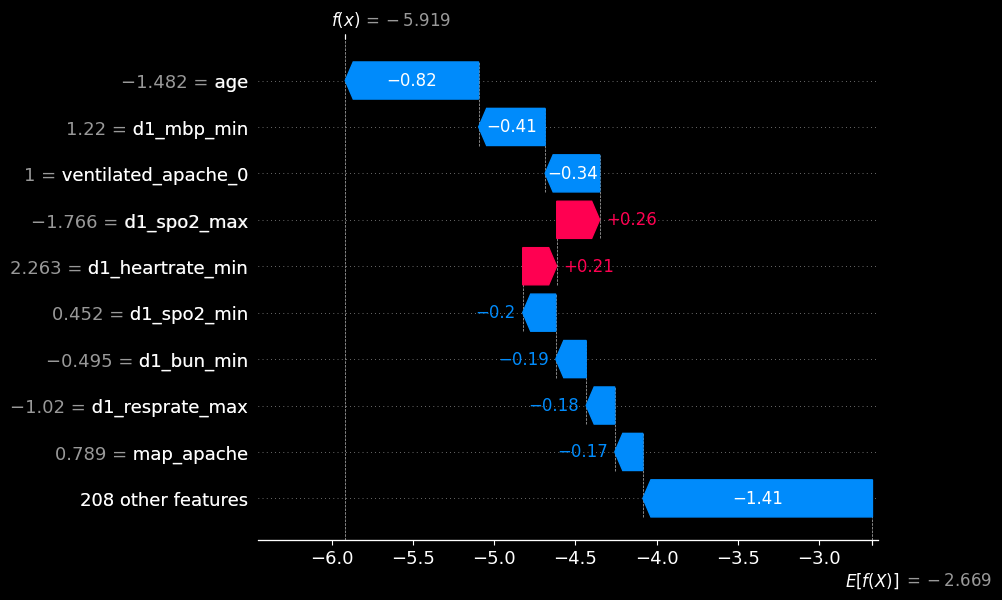

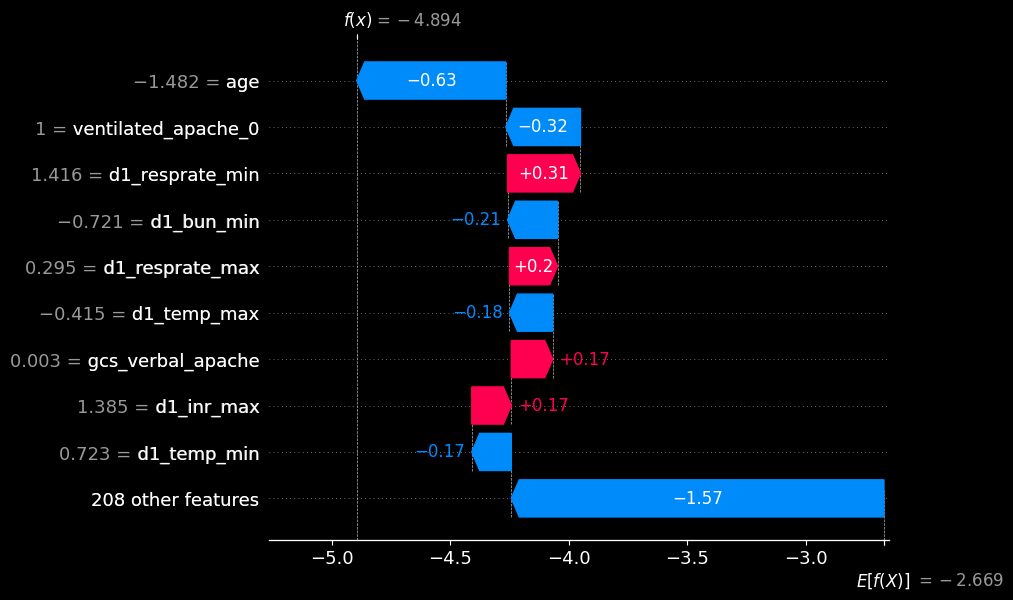

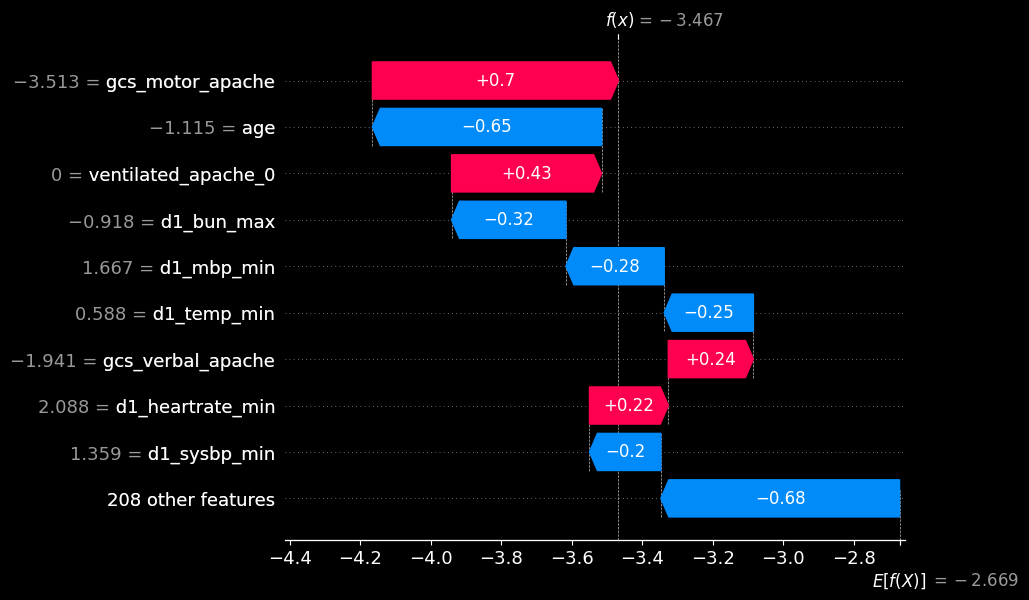

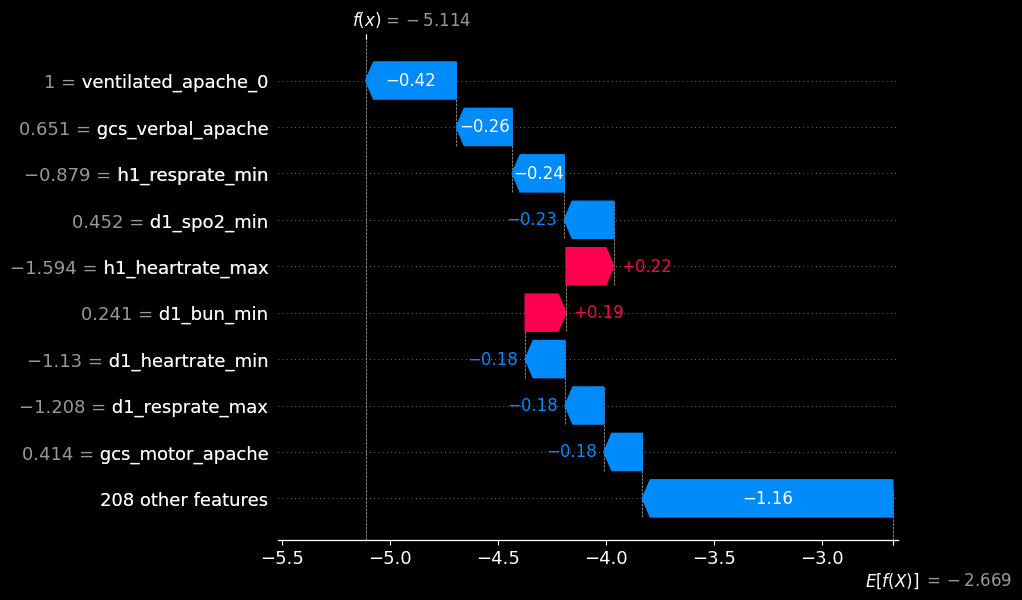

In [ ]:
# Visualize the shapley values for the prediction of the first datapoint of each half
# of each split using a waterfall plot

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

white_sample = white_pts_X.sample(1)
nonwhite_sample = nonwhite_pts_X.sample(1)
male_sample = male_pts_X.sample(1)
female_sample = female_pts_X.sample(1)
old_sample = older65_pts_X.sample(1)
young_sample = younger65_pts_X.sample(1)
selected = np.vstack([white_sample, nonwhite_sample, male_sample, female_sample, old_sample, young_sample])

shap_explainer = shap.Explainer(xgb_model)
shap_values = shap_explainer(selected)
shap_values.feature_names = X_test.columns.tolist()

names = ["white_sample", "nonwhite_sample", "male_sample", "female_sample", "old_sample", "young_sample"]
for i in range(len(selected)):
    shap.waterfall_plot(shap_values[i])
    plt.show()

# Used the following resources to help me write the above code:
# https://github.com/shap/shap/issues/1420
# https://www.youtube.com/watch?v=X6ehVmlV2Go

(l) Answer this question in your report

## Problem 2. Delving into Disparities

(a)

In [ ]:
# Split the training set into cohorts the same way you split the test set before

X_train_raw['AgeGroup'] = pd.cut(X_train_raw['age'], bins=range(0, 90, 5), right=False)
X_test_raw['AgeGroup'] = pd.cut(X_test_raw['age'], bins=range(0, 90, 5), right=False)

#  used the following resource to help me make these plots: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html

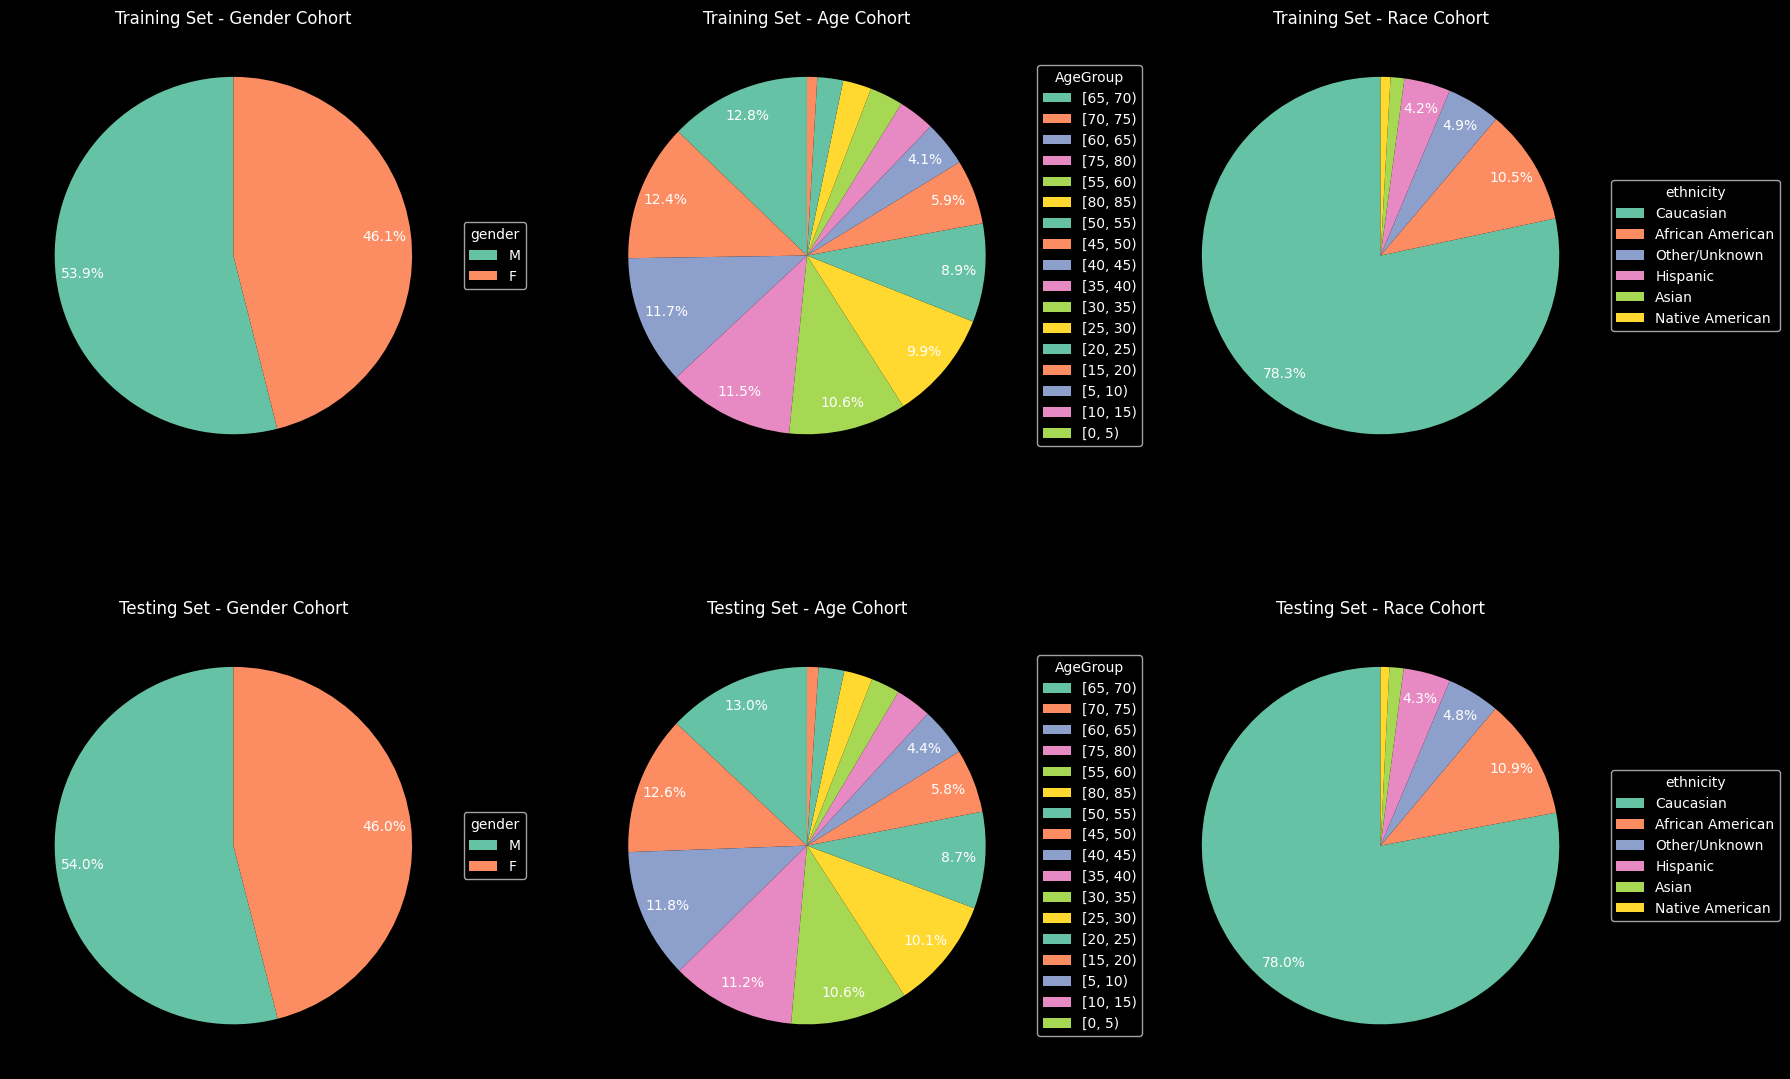

In [ ]:
# Plot the distributions, each on a different pie chart

import matplotlib.pyplot as plt

def custom_autopct(percent):
    return f'{percent:.1f}%' if percent >= 4 else ''

def create_pie_chart(dataset, feature, axis, chart_title, custom_colors):
    value_counts = dataset[feature].value_counts()
    pie_elements, label_elements, percentage_labels = axis.pie(
        value_counts,
        labels=None,
        autopct=custom_autopct,
        startangle=90,
        colors=custom_colors,
        pctdistance=0.85
    )
    axis.legend(
        pie_elements,
        value_counts.index,
        title=feature,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        facecolor='black',
        fontsize=10
    )
    axis.set_title(chart_title, color='white')


plt.style.use('dark_background')
custom_palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
figure, axes = plt.subplots(2, 3, figsize=(18, 12), facecolor='black')


create_pie_chart(X_train_raw, 'ethnicity', axes[0, 2], 'Training Set - Race Cohort', custom_palette)
create_pie_chart(X_test_raw, 'ethnicity', axes[1, 2], 'Testing Set - Race Cohort', custom_palette)

create_pie_chart(X_train_raw, 'gender', axes[0, 0], 'Training Set - Gender Cohort', custom_palette)
create_pie_chart(X_test_raw, 'gender', axes[1, 0], 'Testing Set - Gender Cohort', custom_palette)

create_pie_chart(X_train_raw, 'AgeGroup', axes[0, 1], 'Training Set - Age Cohort', custom_palette)
create_pie_chart(X_test_raw, 'AgeGroup', axes[1, 1], 'Testing Set - Age Cohort', custom_palette)


plt.tight_layout()
plt.show()

#  used the following resource to help me make these plots: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html

(b)

In [ ]:
def drop_rows_criteria(df: pd.DataFrame,
                       outcome: pd.DataFrame,
                       pct_drop: float) -> pd.DataFrame:
    """
    Return two new versions of a dataset and the corresponding outcome
    without some rows based on a certain criteria
    (to change in the code of this function)

    Args:
        df (pd.DataFrame): initial dataset, pandas DataFrame format
        outcome (pd.DataFrame): outcome dataset, pandas DataFrame format
        pct_drop (float): percentage of chance to drop a value
            if a certain criteria is met

    Returns:
        pd.DataFrame: modified dataset
        pd.DataFrame: modified outcome

    Example:
        X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train)
    """
    df2 = df.copy(deep=True).reset_index(drop=True)  # work on a copy of the dataframe
    outcome2 = outcome.copy(deep=True).reset_index(drop=True)
    indices_to_drop = []

    # Local rng for better reproducibility
    rng = np.random.default_rng(seed=42)
    for i in range(len(df2)):
        if df2.iat[i, df2.columns.get_loc("gender")] != "M":

            if rng.random() < pct_drop:  # pct_drop chance to drop this row
                indices_to_drop.append(i)
    df2.drop(indices_to_drop, axis=0, inplace=True)
    outcome2.drop(indices_to_drop, axis=0, inplace=True)
    return df2, outcome2


In [ ]:
from tqdm import tqdm
from xgboost import XGBClassifier
import pandas as pd
from sklearn.pipeline import Pipeline
from IPython.display import display

report = {}
percentages = [0.2, 0.4, 0.6, 0.8]
for pct in tqdm(percentages):

    # Use drop_rows_criteria to drop pct% of the training data
    X_train_raw2, y_train2 = drop_rows_criteria(X_train_raw, y_train, pct)

    # Create a fresh preprocessing pipeline
    preprocessing_pipeline2 = Pipeline(
        steps=[("preprocessing", preprocessing)]
    )

    # Fit the preprocessing pipeline to the new training set and store the
    # normalized version of that set in X_train2
    X_train2 = preprocessing_pipeline2.fit_transform(X_train_raw2)

    # Extract new feature names
    features_names = list(preprocessing_pipeline2[0].transformers_[0][2]) + list(preprocessing_pipeline2[0].transformers_[1][1].get_feature_names_out())
    clean_feature_names = [name.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(',', '').replace(' ', '_') for name in features_names]

    X_train2 = pd.DataFrame(X_train2, columns=clean_feature_names)  # to dataframe type
    X_test2 = pd.DataFrame(preprocessing_pipeline2.transform(X_test_raw), columns=clean_feature_names)

    # Split the new test data (X_test2) into male and female cohorts
    male_indices = X_test_raw['gender'] == 'M'
    female_indices = X_test_raw['gender'] != 'M'

    X_test2_male = X_test2[male_indices.values]
    y_test2_male = y_test[male_indices.values]

    X_test2_female = X_test2[female_indices.values]
    y_test2_female = y_test[female_indices.values]

    # Create, fit, and evaluate your model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train2, y_train2)

    general_metrics = evaluate_model(model, X_test2, y_test)
    male_metrics = evaluate_model(model, X_test2_male, y_test2_male)
    female_metrics = evaluate_model(model, X_test2_female, y_test2_female)

    report[pct] = {
        "General": general_metrics,
        "Male Cohort": male_metrics,
        "Female Cohort": female_metrics
    }

# report results in a table
data = []

for pct, metrics in report.items():
    for cohort, values in metrics.items():
        row = {
            'Reduction Percentage': pct,
            'Cohort': cohort,
            **values
        }
        data.append(row)

results_df = pd.DataFrame(data)
display(results_df)



  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:52:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 25%|██▌       | 1/4 [00:12<00:37, 12.46s/it]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:52:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 50%|█████     | 2/4 [00:24<00:24, 12.00s/it]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:53:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 75%|███████▌  | 3/4 [00:37<00:12, 12.68s/it]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:53:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

,Reduction Percentage,Cohort,Accuracy,Precision,Recall,F1 Score,AUC
0,0.2,General,0.928256,0.663845,0.345936,0.454847,0.890143
1,0.2,Male Cohort,0.928680,0.656682,0.338480,0.446708,0.891408
2,0.2,Female Cohort,0.927759,0.671756,0.354362,0.463972,0.888636
3,0.4,General,0.928256,0.663450,0.346566,0.455298,0.889848
4,0.4,Male Cohort,0.928074,0.645089,0.343230,0.448062,0.889333
5,0.4,Female Cohort,0.928470,0.685039,0.350336,0.463588,0.890394
6,0.6,General,0.927166,0.651023,0.340895,0.447477,0.884680
7,0.6,Male Cohort,0.927973,0.641758,0.346793,0.450270,0.887461
8,0.6,Female Cohort,0.926220,0.662234,0.334228,0.444246,0.881417
9,0.8,General,0.927983,0.666667,0.335224,0.446122,0.880644
